In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve,auc,roc_auc_score

# Data Loading and Cleaning

In [2]:
if not os.path.isfile('train.db'):
    start=datetime.now()
    disk_engine=create_engine('sqlite:///train.db')
    start=dt.datetime.now()
    chunksize=180000
    j=0
    index_start=1
    for df in pd.read_csv('Train.csv',names=['Id','Title','Body','Tags'],iterator=True,encoding='utf-8'):
        df.index +=index_start
        j=j+1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data',disk_engine,if_exists='append')
        index_start=df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)    

# Counting the number of Rows

In [3]:
if os.path.isfile('train.db'):
    start=datetime.now()
    con=sqlite3.connect('train.db')
    num_rows=pd.read_sql_query(" SELECT count(*) from data",con)
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")

Number of rows in the database : 
 6034196
Time taken to count the number of rows : 0:01:40.681160


# Checking for duplicates

In [4]:
if os.path.isfile('train.db'):
    start=datetime.now()
    con=sqlite3.connect('train.db')
    df_no_dup=pd.read_sql_query("SELECT Title,Body,Tags,Count(*) as cnt_dup from data GROUP BY Title,Body,Tags ",con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print('Please download the train.db file from drive or run the above cell to genarate train.db file')

Time taken to run this cell : 0:29:43.885030


In [5]:
df_no_dup.head()

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [6]:
print('number of duplicate questions',(num_rows['count(*)'].values[0]) - df_no_dup.shape[0],"(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

number of duplicate questions 1827881 ( 30.2920389063 % )


In [7]:
# number of times each question appeared in our database
df_no_dup.cnt_dup.value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: cnt_dup, dtype: int64

In [4]:
#This method seems more appropriate to work with this much data.
#creating the connection with database file.
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cells to genarate train.db file")

Time taken to run this cell : 0:01:33.904373


In [5]:
tag_data.head()

,Tags
1,c# silverlight data-binding
2,c# silverlight data-binding columns
3,jsp jstl
4,java jdbc
5,facebook api facebook-php-sdk


# Ananlysis of the Tag

# Total Number of unique Tag

In [10]:
vectorizer=CountVectorizer(tokenizer=lambda x:x.split())
tag_dtm=vectorizer.fit_transform(tag_data['Tags'])

In [11]:
print('Total number of the Tags',tag_dtm.shape[0])
print('Total Number of the Unique tags',tag_dtm.shape[1])

Total number of the Tags 4206314
Total Number of the Unique tags 42048


In [12]:
tags=vectorizer.get_feature_names()
print('Some of the tags we have',tags[0:10])

Some of the tags we have ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


In [13]:
#frequency of each tags
freq=tag_dtm.sum(axis=0).A1
results=dict(zip(tags,freq))

In [14]:
#saving this file as dictionary
if not os.path.isfile('tags_count_dict_dtm.csv'):
    with open('tags_count_dict_dtm.csv','w') as csv_file:
        writer=csv.writer(csv_file)
        for key,value in results.items():
            writer.writerow([key,value])      

In [15]:
tag_df=pd.read_csv('tags_count_dict_dtm.csv',names=['Tags','Counts'])
tag_df.head()

,Tags,Counts
0,nscountedset,3
1,.net-gadgeteer,12
2,null-object-pattern,23
3,urwid,11
4,actual,8


In [16]:
tag_df_sorted=tag_df.sort_values(['Counts'],ascending=False)
tag_counts=tag_df_sorted['Counts'].values

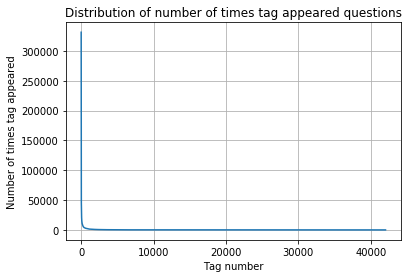

In [17]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

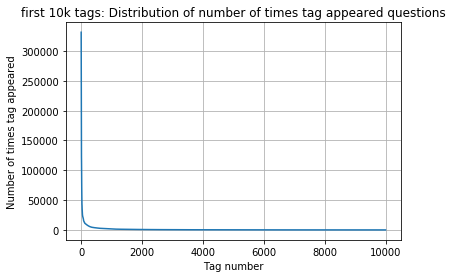

In [18]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
#print(len(tag_counts[0:10000:25]), tag_counts[0:10000:25])

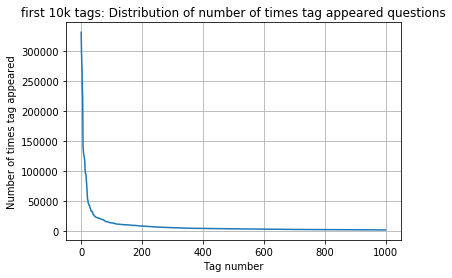

In [19]:
plt.plot(tag_counts[0:1000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
#print(len(tag_counts[0:1000:25]), tag_counts[0:1000:25])

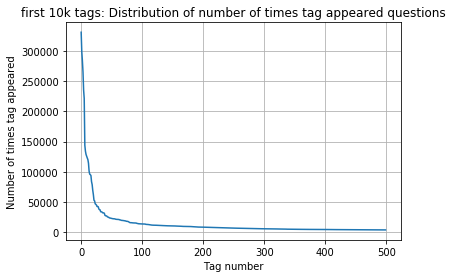

100 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483]


In [20]:
plt.plot(tag_counts[0:500])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

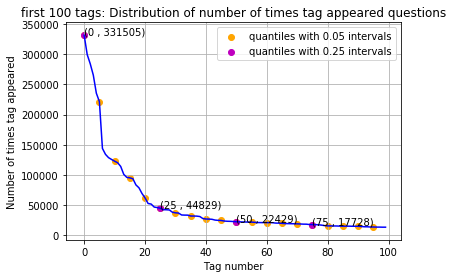

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [21]:
plt.plot(tag_counts[0:100],c='b')
plt.scatter(x=list(range(0,100,5)),y=tag_counts[0:100:5],c='orange',label="quantiles with 0.05 intervals")
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")
for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [22]:
lst_tags_gt_10k=tag_df[tag_df.Counts>10000].Tags
print('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))

153 Tags are used more than 10000 times


In [23]:
lst_tags_gt_100k=tag_df[tag_df.Counts > 100000].Tags
print('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

14 Tags are used more than 100000 times


# Tags per Question

In [24]:
tag_quest_count=tag_dtm.sum(axis=1).tolist()
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:10])

We have total 4206314 datapoints.
[3, 4, 2, 2, 3, 3, 2, 2, 2, 2]


In [25]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899440


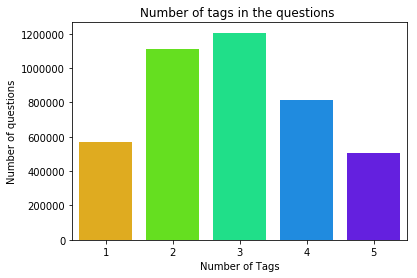

In [26]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

Observations:
1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.899
4. Most of the questions are having 2 or 3 tags

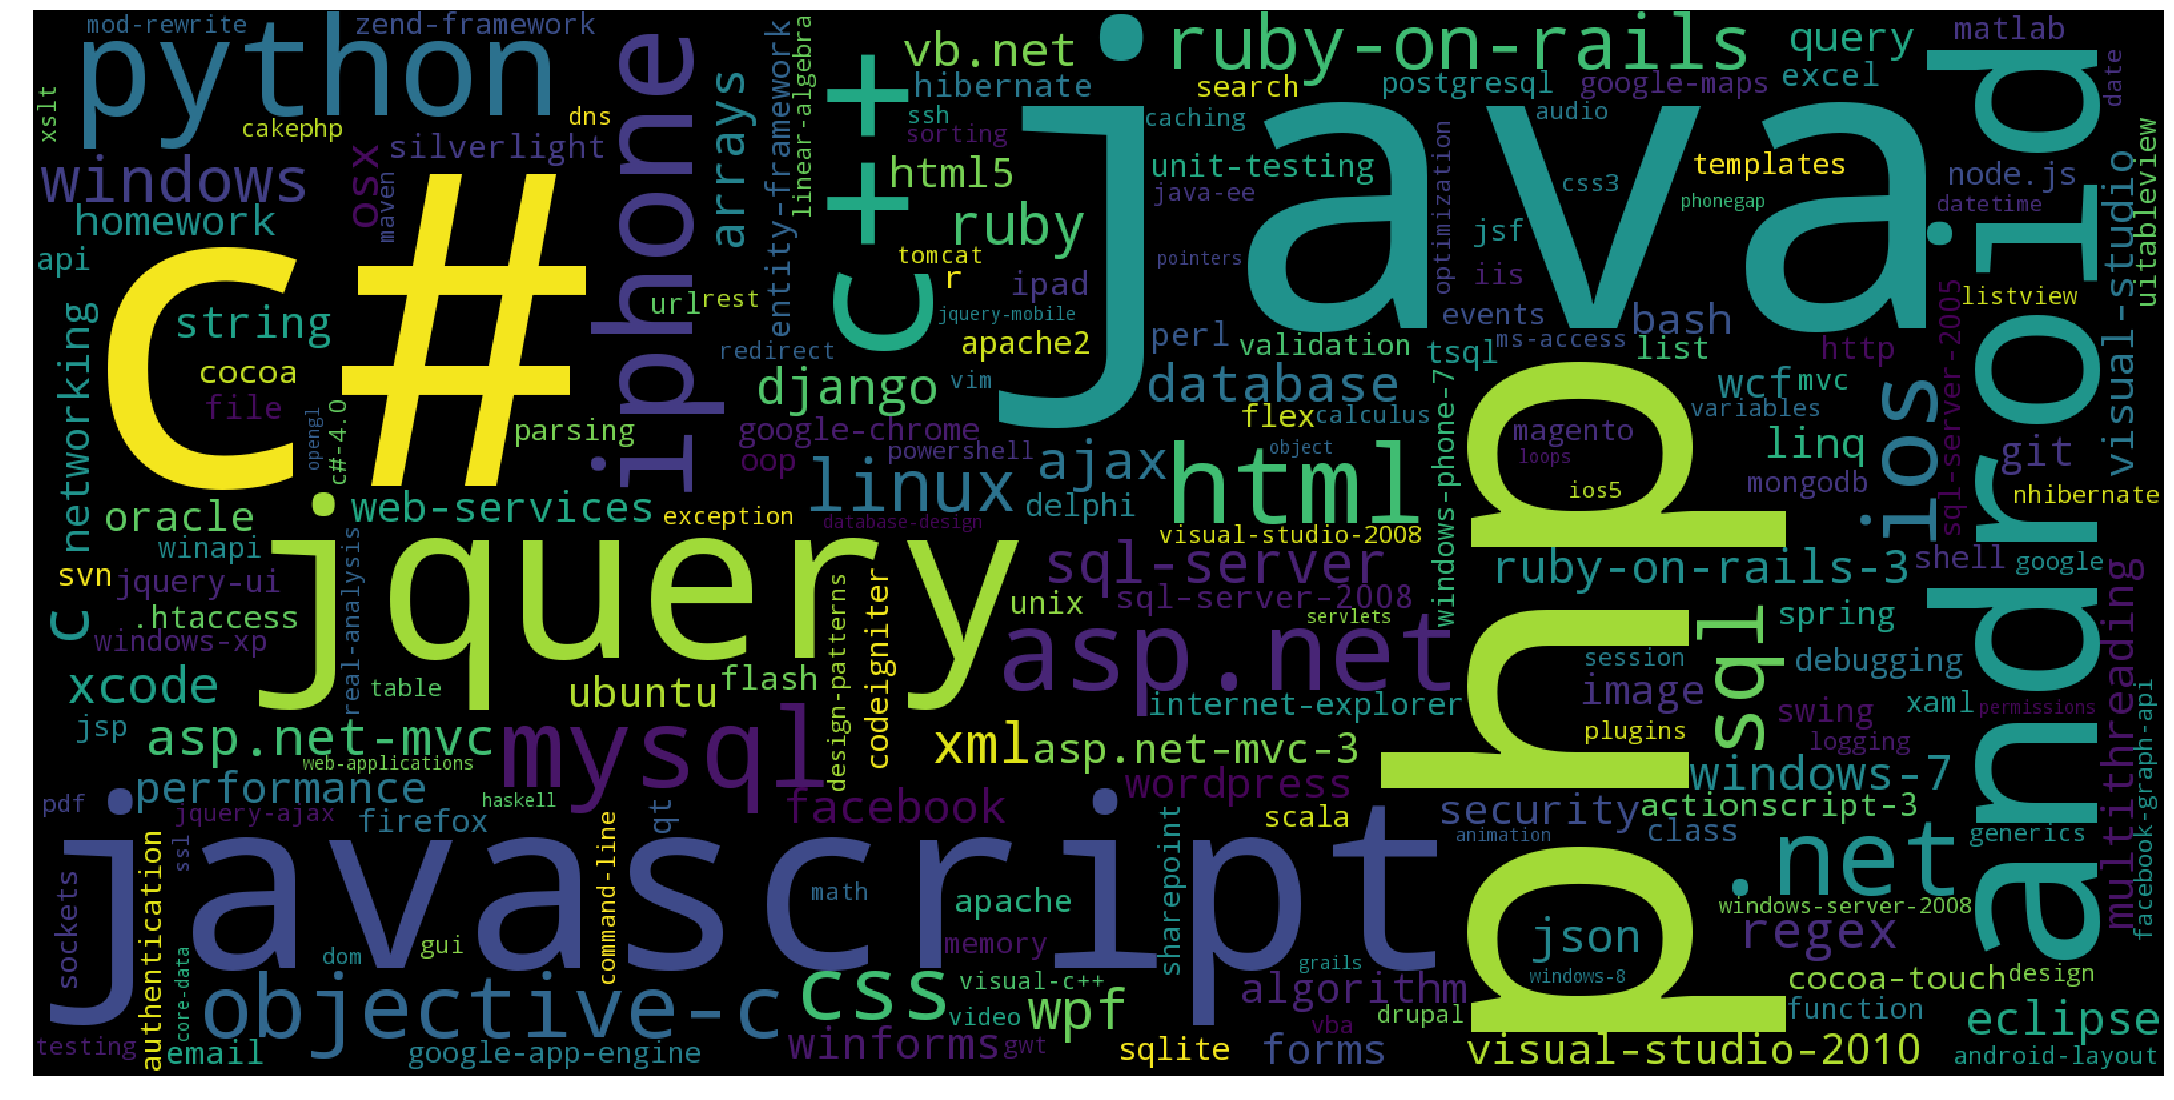

Time taken to run this cell : 0:00:02.880949


In [27]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(results.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

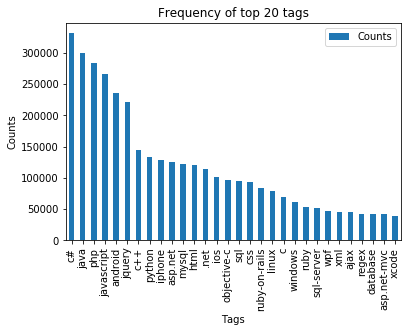

In [28]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

# Cleaning and Prepreocessing of the Questions

In [2]:
def strip_html(data):
    cleanr=re.compile('<.*?>')
    cleantext=re.sub(cleanr,' ',str(data))
    return cleantext
stop_words=set(stopwords.words('english'))
stemmer=SnowballStemmer('english')

In [3]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [6]:
start=datetime.now()
read_db='train_no_dup.db'
write_db='Processed.db'
if os.path.isfile(read_db):
    conn_r=create_connection(read_db)
    if conn_r is not None:
        reader=conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 1000000;")
if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)        

Tables in the databse:
QuestionsProcessed
Cleared All the rows
Time taken to run this cell : 0:13:03.426826


In [7]:
start=datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0

for row in reader:
    is_code=0
    title, question, tags = row[0], row[1], row[2]
    if '<code>' in question:
        questions_with_code=questions_with_code +1
        is_code=1
    x = len(question)+len(title)
    len_pre+=x
    code=str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=strip_html(question.encode('utf-8'))
    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
number of questions completed= 600000
number of questions completed= 700000
number of questions completed= 800000
number of questions completed= 900000
Avg. length of questions(Title+Body) before processing: 1169
Avg. length of questions(Title+Body) after processing: 326
Percent of questions containing code: 57
Time taken to run this cell : 0:20:25.153173


In [9]:
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [10]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('cento server migrat larger disk cento server run whm cpanel mysql apach bind email daemon server server disk full dell poweredg space sas disk setup mirror raid two disk current server sas gb drive need get space avail server unsur go would guy suggest get space purchas two gb sas drive replac gb drive want run new larger drive mirror configur well thought tri pull one disk mirror configur put larger disk let system tri rebuild array howev worri could caus problem larger disk may even accept array raid array becam corrupt unus stuck bare metal restor backup like avoid like plagu also thought put larger disk anoth free poweredg lay around move data exist server server experi offlin howev sure best way go method go go boot server live cds destin server larger disk would format new gb disk partit file system mount root partit would setup rsync daemon abl push root partit sourc server smaller disk would mount root drive rsync avh everyth destin server new roo

In [8]:
#Taking 1 Million entries to a dataframe.
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [9]:
preprocessed_data.head()

,question,tags
0,redirect request revers proxi creat websit asp...,asp.net
1,cento server migrat larger disk cento server r...,migration centos space hard-drive centos5
2,find first digit textbox valu asp net javascri...,asp.net javascript
3,popul control via ajax javascript javascript d...,javascript asp.net ajax
4,find everi ring homomorph mathbb mathbb one pr...,homework abstract-algebra


In [10]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 999999
number of dimensions : 2


# Machine Learning Models

# Convertings tags into MultiLabels Problem

In [11]:
vectorizer=CountVectorizer(tokenizer=lambda x:x.split(),binary=True)
multilabel_y=vectorizer.fit_transform(preprocessed_data['tags'])

In [4]:
def tags_to_choose(n):
    t=multilabel_y.sum(axis=0).tolist()[0]
    sorted_tag_i=sorted(range(len(t)),key=lambda i:t[i],reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tag_i[:n]]
    return multilabel_yn    

In [5]:
def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [41]:
questions_explained=[]
total_tags=multilabel_y.shape[0]
total_qs=preprocessed_data.shape[0]
for i in range(500,total_tags,100):
    questions_explained.append(np.round(((total_qs - questions_explained_fn(i))/total_qs)*100,3))

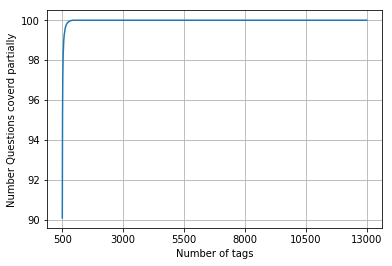

with  5500 tags we are covering  99.023 % of questions


In [42]:
fig,ax=plt.subplots()
ax.plot(questions_explained)

xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [ ]:
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

In [63]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 35395
number of tags taken : 500 ( 1.4126289023873428 %)


# Spiliting the Data into Train and Test Dataset(80:20)

In [64]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)
x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [65]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (799999, 500)
Number of data points in test data : (200000, 500)


# Featurizing the data

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

# Note: Runninh the 1Million Data points casusing the Memory error So I will Sample my data to 0.5Million

# <h2> Modeling with less data points (0.5M data points) and more weight to title and 500 tags only. </h2>

In [6]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [7]:
read_db = 'train_no_dup.db'
write_db = 'Titlemoreweight.db'
train_datasize = 400000
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        # for selecting first 0.5M rows
        reader.execute("SELECT Title, Body, Tags From no_dup_train LIMIT 500001;")
        # for selecting random points
        #reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 500001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
            

Tables in the databse:
QuestionsProcessed
Cleared All the rows


# Preprocessing of the Questions

In [8]:
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=strip_html(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
Avg. length of questions(Title+Body) before processing: 1239
Avg. length of questions(Title+Body) after processing: 424
Percent of questions containing code: 57
Time taken to run this cell : 0:25:01.833482


In [9]:
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [10]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('dynam datagrid bind silverlight dynam datagrid bind silverlight dynam datagrid bind silverlight bind datagrid dynam code wrote code debug code block seem bind correct grid come column form come grid column although necessari bind nthank repli advance..',)
----------------------------------------------------------------------------------------------------
('java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid follow guid link instal jstl got follow error tri launch jsp page java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid taglib declar instal jstl 1.1 tomcat webapp tri project work also tri version 1.2 jstl still messag caus solv',)
----------------------------------------------------------------------------------------------------
('java.sql.sqlexcept microsoft odbc driver

In [11]:
#Taking 0.5 Million entries to a dataframe.
write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [12]:
preprocessed_data.head()

,question,tags
0,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding
1,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding columns
2,java.lang.noclassdeffounderror javax servlet j...,jsp jstl
3,java.sql.sqlexcept microsoft odbc driver manag...,java jdbc
4,better way updat feed fb php sdk better way up...,facebook api facebook-php-sdk


In [13]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 500000
number of dimensions : 2


In [14]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [15]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

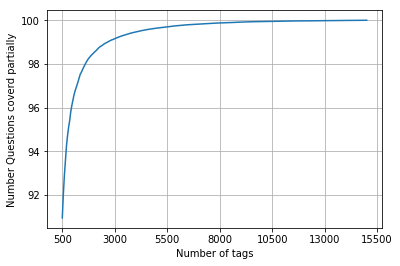

with  5500 tags we are covering  99.157 % of questions
with  500 tags we are covering  90.956 % of questions


In [20]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [16]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 45221 out of  500000


In [17]:
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 400000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [18]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (400000, 500)
Number of data points in test data : (100000, 500)


In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])

print("Time taken to run this cell :", datetime.now() - start)

In [25]:
x_test_multilabel = vectorizer.transform(x_test['question'])

In [28]:
from scipy import sparse
#x_test_multilabel=sparse.save_npz("x_test_multilabel.npz",x_test_multilabel)
x_test_multilabel=sparse.load_npz('x_test_multilabel.npz')

In [29]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 94927) Y : (400000, 500)
Dimensions of test data X: (100000, 94927) Y: (100000, 500)


# <h3> Applying Logistic Regression with OneVsRest Classifier </h3>

In [38]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.23639
Hamming loss  0.0027813
Micro-average quality numbers
Precision: 0.7220, Recall: 0.3251, F1-measure: 0.4483
Macro-average quality numbers
Precision: 0.5481, Recall: 0.2572, F1-measure: 0.3342
              precision    recall  f1-score   support

           0       0.95      0.64      0.76      5519
           1       0.69      0.26      0.38      8190
           2       0.81      0.38      0.52      6529
           3       0.81      0.43      0.56      3231
           4       0.81      0.41      0.54      6430
           5       0.82      0.34      0.48      2879
           6       0.87      0.50      0.63      5086
           7       0.87      0.54      0.67      4533
           8       0.60      0.13      0.22      3000
           9       0.81      0.52      0.63      2765
          10       0.60      0.17      0.26      3051
          11       0.70      0.33      0.45      3009
          12       0.65      0.24      0.35      2630
          13       0.71      0.2

In [31]:
joblib.dump(classifier, 'lr_with_more_title_weight.pkl') 

['lr_with_more_title_weight.pkl']

In [35]:
start = datetime.now()
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l1',solver='liblinear'))
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro',labels=np.unique(predictions_2))
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro',labels=np.unique(predictions_2))
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.2511
Hamming loss  0.0027029
Micro-average quality numbers
Precision: 0.7172, Recall: 0.3673, F1-measure: 0.4858
Macro-average quality numbers
Precision: 0.5570, Recall: 0.2951, F1-measure: 0.3710
              precision    recall  f1-score   support

           0       0.94      0.72      0.82      5519
           1       0.70      0.34      0.45      8190
           2       0.80      0.42      0.55      6529
           3       0.82      0.49      0.61      3231
           4       0.80      0.44      0.57      6430
           5       0.82      0.38      0.52      2879
           6       0.86      0.53      0.66      5086
           7       0.87      0.58      0.70      4533
           8       0.60      0.13      0.22      3000
           9       0.82      0.57      0.67      2765
          10       0.60      0.20      0.30      3051
          11       0.68      0.38      0.49      3009
          12       0.62      0.29      0.40      2630
          13       0.73      0.30

D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedM

# Featurizing the Data with Bag of Words

In [20]:
start = datetime.now()
vectorizer_bow = CountVectorizer(min_df=0.00009, max_features=50000,tokenizer = lambda x: x.split(),ngram_range=(1,3))

In [19]:
import scipy.sparse
x_train_multilabel_bow=scipy.sparse.load_npz('x_train_multilabel_bow.npz')
x_train_multilabel_bow.shape

(400000, 50000)

In [20]:
#x_test_multilabel_bow = vectorizer_bow.transform(x_test['question']) 

In [21]:
x_test_multilabel_bow=scipy.sparse.load_npz('x_test_multilabel_bow.npz')
x_test_multilabel_bow.shape

(100000, 50000)

In [22]:
print("Dimensions of train data X:",x_train_multilabel_bow.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel_bow.shape,"Y:",y_test.shape) 

Dimensions of train data X: (400000, 50000) Y : (400000, 500)
Dimensions of test data X: (100000, 50000) Y: (100000, 500)


In [36]:
start = datetime.now()
classifier_3 = OneVsRestClassifier(LogisticRegression(penalty='l1',solver='liblinear'))
classifier_3.fit(x_train_multilabel_bow, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)

In [42]:
predictions_3 = classifier_3.predict(x_test_multilabel_bow)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_3))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_3))


precision = precision_score(y_test, predictions_3, average='micro')
recall = recall_score(y_test, predictions_3, average='micro')
f1 = f1_score(y_test, predictions_3, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_3, average='macro')
recall = recall_score(y_test, predictions_3, average='macro')
f1 = f1_score(y_test, predictions_3, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_3))


Accuracy : 0.21167
Hamming loss  0.00314744
Micro-average quality numbers
Precision: 0.5654, Recall: 0.4090, F1-measure: 0.4746
Macro-average quality numbers
Precision: 0.4475, Recall: 0.3352, F1-measure: 0.3799
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      5519
           1       0.54      0.40      0.46      8190
           2       0.64      0.46      0.54      6529
           3       0.68      0.53      0.59      3231
           4       0.66      0.49      0.56      6430
           5       0.62      0.41      0.49      2879
           6       0.74      0.56      0.64      5086
           7       0.75      0.62      0.68      4533
           8       0.36      0.18      0.24      3000
           9       0.69      0.60      0.64      2765
          10       0.44      0.30      0.35      3051
          11       0.58      0.45      0.51      3009
          12       0.49      0.36      0.41      2630
          13       0.53      0.

# Performed hyperparam tuning on alpha (or lambda) for Logistic regression to improve the performance using GridSearch 

In [26]:
tuned_parameter={'estimator__alpha':np.logspace(-2,2,5)}
classifier_5 = OneVsRestClassifier(SGDClassifier(loss='log',penalty='l1'))
grid=GridSearchCV(classifier_5,param_grid=tuned_parameter,cv=3)
grid.fit(x_train_multilabel_bow,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'estimator__alpha': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [27]:
grid.best_params_

{'estimator__alpha': 0.01}

In [28]:
classifier_6 = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.01, penalty='l1'), n_jobs=-1)
classifier_6.fit(x_train_multilabel_bow, y_train)
predictions_6 = classifier_6.predict (x_test_multilabel_bow)

In [29]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions_6))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_6))


precision = precision_score(y_test, predictions_6, average='micro')
recall = recall_score(y_test, predictions_6, average='micro')
f1 = f1_score(y_test, predictions_6, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_6, average='macro')
recall = recall_score(y_test, predictions_6, average='macro')
f1 = f1_score(y_test, predictions_6, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_6))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.16721
Hamming loss  0.00317972
Micro-average quality numbers
Precision: 0.7692, Recall: 0.1219, F1-measure: 0.2104
Macro-average quality numbers
Precision: 0.0650, Recall: 0.0183, F1-measure: 0.0272
              precision    recall  f1-score   support

           0       0.90      0.55      0.69      5519
           1       0.52      0.13      0.21      8190
           2       0.83      0.25      0.38      6529
           3       0.77      0.27      0.40      3231
           4       0.88      0.28      0.43      6430
           5       0.75      0.20      0.32      2879
           6       0.84      0.50      0.63      5086
           7       0.89      0.46      0.60      4533
           8       0.42      0.15      0.23      3000
           9       0.80      0.32      0.46      2765
          10       0.55      0.05      0.10      3051
          11       0.78      0.28      0.41      3009
          12       0.58      0.15      0.24      2630
          13       0.00      0.

# Apply SGDClassifier with Hinge Loss 

In [23]:
start = datetime.now()
classifier_4 = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier_4.fit(x_train_multilabel_bow, y_train)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:07:40.129525


In [24]:
predictions_4 = classifier_4.predict(x_test_multilabel_bow)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_4))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_4))


precision = precision_score(y_test, predictions_4, average='micro')
recall = recall_score(y_test, predictions_4, average='micro')
f1 = f1_score(y_test, predictions_4, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_4, average='macro')
recall = recall_score(y_test, predictions_4, average='macro')
f1 = f1_score(y_test, predictions_4, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_4))

Accuracy : 0.10993
Hamming loss  0.00591364
Micro-average quality numbers
Precision: 0.2888, Recall: 0.4793, F1-measure: 0.3604
Macro-average quality numbers
Precision: 0.2085, Recall: 0.4072, F1-measure: 0.2679
              precision    recall  f1-score   support

           0       0.74      0.80      0.77      5519
           1       0.44      0.45      0.44      8190
           2       0.53      0.52      0.52      6529
           3       0.49      0.60      0.54      3231
           4       0.53      0.55      0.54      6430
           5       0.43      0.49      0.46      2879
           6       0.59      0.62      0.60      5086
           7       0.59      0.66      0.63      4533
           8       0.23      0.22      0.23      3000
           9       0.57      0.65      0.61      2765
          10       0.31      0.35      0.33      3051
          11       0.44      0.54      0.48      3009
          12       0.35      0.47      0.40      2630
          13       0.36      0.

# Observation

1. I have loaded the data using Pandas and SQLLite 
2. I have performed simple exploratory data analysis , I have counted the number of rows ,checked the duplicates
3. I have analysed the total number of Unique Tags by applying CountVectorizer() found out the count of the each tags
4. I have also printed the total no. of questions each tag and the top 20 frequent tags
5. I have taken only 0.5M data as running on the whole dataset is computationaly challenged
5. I have performed  data preprocessing and cleaning for removing code snippet from body ,special characters,HTML tags,
   convert all the characters into small letters
6. I have converted the tags for Multilabels classification  problem
7. I have spillited the dataset into train and test (80:20)
8. I have performed featurization of the text data using TFidfVectorizer() by taking n_gram=3
9. I have run the OneVSRestClassifier() and printed the Acccuracy,the Hamming loss and the F1Score
8. I have used bag of words as featurization technique with n_gram=3 and run the OneVsRestClassifier with LogisticRegression
   and Printed the Accuracy , Hamming Loss and F1Score
9. I have performed Hyperparameter tunning of alpha with the GridSearchCV for SGDClassifier(loss='log') and run the model 
   printed the Accuracy, Hamming Loss, and F1Score
10.I have run the OneVSRestClassifier with SGDClassifier(loss='hinge') and printed the Accuracy, Hamming loss and F1Score     